Diego Toribio <br>
Professor Fred Fontaine <br>
EID-378 Finance <br>
Problem Set III: MPT and Risk<br>

In [2]:
!pip install yfinance --quiet

In [3]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In this assignment, you will be exploring:

- Modern Portfolio Theory, including concepts such as the \( \beta \) and Sharpe ratio.
- V@R and CV@R risk measures, including their application to portfolio optimization (as an alternative to MPT).

## Section 1 - Preparing the Data

1. Select **M = 5** stocks, and get the daily adjusted closing price over one year for them.

2. Also get the S&P 500 index (daily) over the same year.

3. We also want to determine a risk-free return to use for our portfolio models, based on 3-Month Treasury Bills. This will be explained separately.

4. Compute the daily returns of the stocks and S&P 500 over the year. In order to have a return for each trading day, you should also grab the last trading day of the previous year. For example, for 2014, you should also grab Dec. 31, 2013, in order to compute the return for the first trading day (Jan. 2) of 2014. This idea is called 'pre-windowing.' It is fine if you determine the last trading day of the previous year "manually" (i.e., rather than writing systematic code that would "always" work).

5. Subtract off the daily risk-free return from the daily returns of the stocks and S&P 500. Going forward, we are going to be working with these excess returns only (I will omit using the word "excess" but keep in mind, everything is excess!). For example, if we think in terms of the Markowitz bullet in the $ (\sigma, \mu) $ plane, the 'risk-free' point in the graph will actually be the origin (0,0). More generally, going forward in the analysis, you can link what is happening here back to the "theory" discussed in the lecture notes by acting as if the risk-free return is 0!


#### 1.1 – Adjusted Close Data Retrieval  
We include the last trading day of the prior year so that our first return can be computed on the first trading day of the target year. Here we download auto‑adjusted close prices for our $M=5$ stocks.


In [4]:
# download adjusted close prices
start_date = "2021-12-31"
end_date = "2022-12-31"
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
stock_data = yf.download(
    tickers, start=start_date, end=end_date, progress=False, auto_adjust=True
)["Close"]

# prepare first five rows for display
df_head = stock_data.head()
rows = [
    [date.strftime("%Y-%m-%d")] + [f"{v:.2f}" for v in row]
    for date, row in df_head.iterrows()
]

print(
    "\n\033[1mTable 1\033[0m. Adjusted Close Prices for Selected Stocks (first five rows)"
)
print(tabulate(rows, headers=["Date"] + list(df_head.columns), tablefmt="pretty"))


Table 1. Adjusted Close Prices for Selected Stocks (first five rows)
+------------+--------+--------+--------+--------+--------+
|    Date    |  AAPL  |  AMZN  |  GOOG  |  MSFT  |  TSLA  |
+------------+--------+--------+--------+--------+--------+
| 2021-12-31 | 174.52 | 166.72 | 144.00 | 327.16 | 352.26 |
| 2022-01-03 | 178.88 | 170.40 | 144.39 | 325.63 | 399.93 |
| 2022-01-04 | 176.61 | 167.52 | 143.74 | 320.05 | 383.20 |
| 2022-01-05 | 171.91 | 164.36 | 137.00 | 307.77 | 362.71 |
| 2022-01-06 | 169.04 | 163.25 | 136.90 | 305.33 | 354.90 |
+------------+--------+--------+--------+--------+--------+


#### 1.2 – S&P 500 Benchmark Retrieval  
Using the same date range (with pre‑window), we pull the S&P 500 adjusted close series and tabulate its first five observations.

In [5]:
# download S&P 500 “Adj Close” over the same date range
sp500 = yf.download(
    "^GSPC", start=start_date, end=end_date, progress=False, auto_adjust=False
)["Adj Close"]

# prepare first five rows, round prices to 2 decimals
df_sp500 = sp500.head().reset_index()
df_sp500.columns = ["Date", "Adj Close"]
rows = [
    [row["Date"].strftime("%Y-%m-%d"), f"{row['Adj Close']:.2f}"]
    for _, row in df_sp500.iterrows()
]

print("\n\033[1mTable 2\033[0m. S&P 500 Adj Close (first five rows, 2 dp).")
print(tabulate(rows, headers=["Date", "Adj Close"], tablefmt="pretty"))


Table 2. S&P 500 Adj Close (first five rows, 2 dp).
+------------+-----------+
|    Date    | Adj Close |
+------------+-----------+
| 2021-12-31 |  4766.18  |
| 2022-01-03 |  4796.56  |
| 2022-01-04 |  4793.54  |
| 2022-01-05 |  4700.58  |
| 2022-01-06 |  4696.05  |
+------------+-----------+


### 1.3 – Per‑Day Risk‑Free Rate

Assuming an annual T‑Bill yield of $2\%$, we convert it to a per‑trading‑day rate by  

$$
r_{\text{daily}} = (1 + r_{\text{ann}})^{1/252} - 1,
$$

and broadcast this constant across our date index to serve as the baseline for excess‑return computations.

In [6]:
# compute daily risk‑free rate from 2% annual T‑Bill
annual_rf_rate = 0.02
daily_rf_rate = (1 + annual_rf_rate) ** (1 / 252) - 1

# create series for subtraction
risk_free_daily = pd.Series(daily_rf_rate, index=stock_data.index)

print(f"Daily risk‑free rate (per trading day): {daily_rf_rate:.6e}")

Daily risk‑free rate (per trading day): 7.858494e-05


### 1.4 – Daily Return

We compute each series’ raw returns by  

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}},
$$

then discard the initial missing value to produce a continuous daily return series for our analysis.

In [7]:
# compute daily returns
stock_returns = stock_data.pct_change().dropna()
sp500_returns = sp500.pct_change().dropna()

# first five rows of stock returns
print("\n\033[1mTable 3\033[0m. Stock daily returns (first five rows)")
rows = [
    [date.strftime("%Y-%m-%d")] + [f"{v:.4f}" for v in row]
    for date, row in stock_returns.head(5).iterrows()
]
print(tabulate(rows, headers=["Date"] + list(stock_returns.columns), tablefmt="pretty"))

# first five rows of S&P 500 returns
df_sp_ret = sp500_returns.head(5).reset_index()
df_sp_ret.columns = ["Date", "SP500 Return"]
rows = [
    [row["Date"].strftime("%Y-%m-%d"), f"{row['SP500 Return']:.4f}"]
    for _, row in df_sp_ret.iterrows()
]
print("\n\033[1mTable 4\033[0m. S&P 500 daily returns (first five rows)")
print(tabulate(rows, headers=["Date", "SP500 Return"], tablefmt="pretty"))


Table 3. Stock daily returns (first five rows)
+------------+---------+---------+---------+---------+---------+
|    Date    |  AAPL   |  AMZN   |  GOOG   |  MSFT   |  TSLA   |
+------------+---------+---------+---------+---------+---------+
| 2022-01-03 | 0.0250  | 0.0221  | 0.0027  | -0.0047 | 0.1353  |
| 2022-01-04 | -0.0127 | -0.0169 | -0.0045 | -0.0171 | -0.0418 |
| 2022-01-05 | -0.0266 | -0.0189 | -0.0468 | -0.0384 | -0.0535 |
| 2022-01-06 | -0.0167 | -0.0067 | -0.0007 | -0.0079 | -0.0215 |
| 2022-01-07 | 0.0010  | -0.0043 | -0.0040 | 0.0005  | -0.0354 |
+------------+---------+---------+---------+---------+---------+

Table 4. S&P 500 daily returns (first five rows)
+------------+--------------+
|    Date    | SP500 Return |
+------------+--------------+
| 2022-01-03 |    0.0064    |
| 2022-01-04 |   -0.0006    |
| 2022-01-05 |   -0.0194    |
| 2022-01-06 |   -0.0010    |
| 2022-01-07 |   -0.0041    |
+------------+--------------+


### 1.5 – Excess Return Calculation

We subtract the constant daily risk‑free rate from each return series and drop any resulting NaNs, yielding stock and S&P 500 returns in excess of the risk‑free rate (first five rows shown in Tables 5 and 6).

In [8]:
# compute excess returns
excess_stock_returns = stock_returns.sub(risk_free_daily, axis=0).dropna()
excess_sp500_returns = sp500_returns.sub(risk_free_daily, axis=0).dropna()

# first five rows of excess stock returns
print("\n\033[1mTable 5\033[0m. Excess stock returns (first five rows)")
rows = [
    [date.strftime("%Y-%m-%d")] + [f"{v:.4f}" for v in row]
    for date, row in excess_stock_returns.head(5).iterrows()
]
print(
    tabulate(
        rows, headers=["Date"] + list(excess_stock_returns.columns), tablefmt="pretty"
    )
)

# first five rows of excess S&P 500 returns
print("\n\033[1mTable 6\033[0m. Excess S&P 500 returns (first five rows)")
df_ex_sp = excess_sp500_returns.head(5).reset_index()
df_ex_sp.columns = ["Date", "Excess SP500 Return"]
rows = [
    [row["Date"].strftime("%Y-%m-%d"), f"{row['Excess SP500 Return']:.4f}"]
    for _, row in df_ex_sp.iterrows()
]
print(tabulate(rows, headers=["Date", "Excess SP500 Return"], tablefmt="pretty"))


Table 5. Excess stock returns (first five rows)
+------------+---------+---------+---------+---------+---------+
|    Date    |  AAPL   |  AMZN   |  GOOG   |  MSFT   |  TSLA   |
+------------+---------+---------+---------+---------+---------+
| 2022-01-03 | 0.0249  | 0.0220  | 0.0027  | -0.0047 | 0.1352  |
| 2022-01-04 | -0.0128 | -0.0170 | -0.0046 | -0.0172 | -0.0419 |
| 2022-01-05 | -0.0267 | -0.0190 | -0.0469 | -0.0385 | -0.0535 |
| 2022-01-06 | -0.0168 | -0.0068 | -0.0008 | -0.0080 | -0.0216 |
| 2022-01-07 | 0.0009  | -0.0044 | -0.0041 | 0.0004  | -0.0355 |
+------------+---------+---------+---------+---------+---------+

Table 6. Excess S&P 500 returns (first five rows)
+------------+---------------------+
|    Date    | Excess SP500 Return |
+------------+---------------------+
| 2022-01-03 |       0.0063        |
| 2022-01-04 |       -0.0007       |
| 2022-01-05 |       -0.0195       |
| 2022-01-06 |       -0.0010       |
| 2022-01-07 |       -0.0041       |
+------------+-----

## Section 2 - Data Analysis
###  Modern Portfolio Theory

#### Some Equations

Let us write some equations (which apply in this form—with the risk-free return already subtracted off). Let $ C $ denote the covariance of the returns of the risky stocks (not the S&P 500), $ \mathbf{m} $ the vector of their expected (excess) returns. Given a portfolio weight vector $ \mathbf{w} $ (satisfying $\sum w_k = 1$), the expected (excess) return and standard deviation for $ \mathbf{w} $ is:

$$
\mu(\mathbf{w}) = \mathbf{m}^T\mathbf{w} \\
\sigma(\mathbf{w}) = \sqrt{\mathbf{w}^T C \mathbf{w}}
$$

Also let $ \mathbf{1} $ denote the vector of all ones, as usual.  
The weight vectors for the MVP and MP are:

$$
\mathbf{w}_{MVP} = \frac{1}{\mathbf{1}^T C^{-1}\mathbf{1}} C^{-1}\mathbf{1} \\
\mathbf{w}_{MP} = \frac{1}{\mathbf{1}^T C^{-1}\mathbf{m}} C^{-1}\mathbf{m}
$$

From these you can compute the $\mu, \sigma$.

If you have two portfolios (of the risky stocks only) with weight vectors $ \mathbf{w}_1, \mathbf{w}_2 $, the corresponding returns $ r_1, r_2 $ have covariance given by:

$$
cov(r_1, r_2) = \mathbf{w}_1^T C \mathbf{w}_2
$$

Otherwise, if you have the actual set of returns over a period of time, you can compute the covariance directly from the data. For example, you can do this to compute the covariance between one of your stocks and the S&P 500. If you store the covariances between each stock and the S&P 500 in a vector $ \mathbf{q} $, then the covariance between a portfolio $ \mathbf{w} $ of the stocks and the S&P 500 would be:

$$
cov(r_{\mathbf{w}}, r_{S\&P500}) = \mathbf{q}^T\mathbf{w}
$$



1. Using the data for the full year, we want to get the vector of expected returns and covariance matrix of the returns of the **M = 5** stocks, and the covariance between each stock and the S&P 500. Compute $ \mathbf{w}_{MVP}, (\sigma_{MVP}, \mu_{MVP}) $ and $ \mathbf{w}_{MP}, (\sigma_{MP}, \mu_{MP}) $ for the minimum variance and market portfolios, respectively. We will also need code that, given a weight vector for a portfolio from the stocks $ \mathbf{w} $, we can compute the $ (\sigma,\mu) $ point; also that we can compute the covariance between two such portfolios; we also want the vector $ \mathbf{q} $ of covariances with the S&P 500, and the ability to compute the covariance of a portfolio given by $ \mathbf{w} $ with the S&P 500.

2. Look at the MVP and MP weight vectors. Do they involve short-selling?

3. Compute the Sharpe ratio and $ \beta $ for each of the **M = 5** stocks, the S&P 500, and the MVP. Compute the covariance between the individual stocks, and the MVP and MP portfolios with the S&P 500. Display these results in a reasonable form, such as a table. Also provide a quick summary of which of these are positively or negatively correlated with the S&P 500.

4. Generate **N = 100** random $ \mathbf{w} $ vectors with **no short selling**; they have to satisfy the constraint that $\sum_{k=1}^{M} w_k = 1$. To do this I suggest: (1) generate $ M $ independent numbers uniformly from 0 to 1, say $(x_1, x_2, \dots, x_5)$, and then (2) set $ w_k = x_k / (\sum x_k) $, i.e., normalize them to sum to 1. I suggest you store these vectors in an array (dataframe) as you will be using them again later!

5. Compute the $ (\sigma, \mu) $ point for each of these vectors, and create a scatter plot of these $ (\sigma, \mu) $, also put in $ (\sigma_{MVP}, \mu_{MVP}) $, and $ (\sigma_{MP}, \mu_{MP}) $ and also compute and plot $ (\sigma_{SP}, \mu_{SP}) $ for the S&P 500. Also draw the CAL on your graph (remember, the "risk-free" point is now (0,0)).

6. Find the median of the expected returns of those 100 portfolios that involve no short-selling, say $ \mu_{med} $. Find the "best" portfolio (among those you created) whose return satisfies $ \mu \geq \mu_{med} $, i.e., among all such, the $ \sigma $ is minimum. Highlight that portfolio. We can consider that portfolio as an approximate solution to an optimization problem (find the portfolio with the no short selling constraint and achieves at least a prescribed expected return that minimizes risk *as measured by standard deviation*). For that optimal portfolio, compute its Sharpe ratio and $ \beta $.


### 2.1 – Mean–Variance Portfolio Construction

We estimate the sample mean vector $\mu$ and covariance matrix $C$ of our five stocks, and the covariance vector $q$ between each stock and the S&P 500.  Closed‐form mean–variance theory then yields

$$
w_{\mathrm{MVP}} = \frac{C^{-1}\mathbf{1}}{\mathbf{1}^\top C^{-1}\mathbf{1}},
\qquad
w_{\mathrm{MP}}  = \frac{C^{-1}\mu}{\mathbf{1}^\top C^{-1}\mu}.
$$

We implement three small helpers—`portfolio_stats`, `covariance`, and `beta`—to compute each portfolio’s $\mu,\;\sigma$, inter‑portfolio covariance, and market beta.

In [19]:
# compute expected returns and covariance matrix
mu_vec = excess_stock_returns.mean()
C_df = excess_stock_returns.cov()
C = C_df.values

# extract S&P 500 series and its variance
sp = sp500_returns.squeeze()
var_sp = float(sp.var(ddof=1))

# covariance vector between stocks and S&P 500
q_df = pd.concat([excess_stock_returns, sp.rename("SP500")], axis=1).cov()
q = q_df.loc[excess_stock_returns.columns, "SP500"].values


# helpers for portfolio statistics
def portfolio_stats(w, mu, cov):
    return float(mu.values @ w), float(np.sqrt(w @ cov @ w))


def beta(w, q_vec, var_sp):
    return float((q_vec @ w) / var_sp)


# invert covariance and create ones vector
C_inv = np.linalg.inv(C)
ones = np.ones(len(mu_vec))

# minimum‑variance portfolio
w_MVP = C_inv @ ones
w_MVP /= ones @ w_MVP
mu_MVP, sigma_MVP = portfolio_stats(w_MVP, mu_vec, C)

# market (tangency) portfolio
w_MP = C_inv @ mu_vec.values
w_MP /= ones @ w_MP
mu_MP, sigma_MP = portfolio_stats(w_MP, mu_vec, C)

# display results
table = [
    ["MVP", *np.round(w_MVP, 4), round(mu_MVP, 4), round(sigma_MVP, 4)],
    ["MP", *np.round(w_MP, 4), round(mu_MP, 4), round(sigma_MP, 4)],
]
print("\n\033[1mTable 7\033[0m. Portfolio Weights and Performance Metrics\n")
print(
    tabulate(
        table,
        headers=["Portfolio", *excess_stock_returns.columns, "μ", "σ"],
        tablefmt="pretty",
    )
)


Table 7. Portfolio Weights and Performance Metrics

+-----------+---------+---------+--------+---------+---------+---------+--------+
| Portfolio |  AAPL   |  AMZN   |  GOOG  |  MSFT   |  TSLA   |    μ    |   σ    |
+-----------+---------+---------+--------+---------+---------+---------+--------+
|    MVP    | 0.5442  | -0.0999 | 0.1044 | 0.5296  | -0.0783 | -0.0009 | 0.021  |
|    MP     | -1.4149 |  0.723  | 1.6975 | -0.8604 | 0.8547  | -0.005  | 0.0508 |
+-----------+---------+---------+--------+---------+---------+---------+--------+


### 2.2 – Short‑Selling Check

We flag any negative weights in the MVP and MP portfolios—indicating short positions—and list the affected tickers in Table 8.

In [21]:
# identify short positions in MVP and MP
results = []
for label, w in [("MVP", w_MVP), ("MP", w_MP)]:
    shorts = [t for t, weight in zip(excess_stock_returns.columns, w) if weight < 0]
    results.append([label, ", ".join(shorts) if shorts else "—"])

print("\n\033[1mTable 8\033[0m. Short Positions in MVP and MP Portfolios\n")
print(tabulate(results, headers=["Portfolio", "Short Positions"], tablefmt="pretty"))


Table 8. Short Positions in MVP and MP Portfolios

+-----------+-----------------+
| Portfolio | Short Positions |
+-----------+-----------------+
|    MVP    |   AMZN, TSLA    |
|    MP     |   AAPL, MSFT    |
+-----------+-----------------+


### 2.3 – Performance Metrics Computation

We calculate for each stock, the S&P 500, and the MVP & MP portfolios:

- **Sharpe** = mean / std  
- **Beta** = Cov(asset, SP) / Var(SP)  
- **Cov w/SP500**

In [22]:
# build table rows
rows = []
for name, series in {
    **{t: excess_stock_returns[t] for t in excess_stock_returns.columns},
    "SP500": sp,
}.items():
    mean = float(series.mean())
    std = float(series.std(ddof=1))
    cov = float(series.cov(sp))
    beta_ = cov / var_sp if name != "SP500" else 1.0
    sharpe = mean / std
    rows.append([name, round(sharpe, 4), round(beta_, 4), round(cov, 4)])

# add MVP and MP
for label, w in [("MVP", w_MVP), ("MP", w_MP)]:
    cov_wp = float(q @ w)
    rows.append(
        [
            label,
            (
                round(mu_MP / sigma_MP, 4)
                if label == "MP"
                else round(mu_MVP / sigma_MVP, 4)
            ),
            round(cov_wp / var_sp, 4),
            round(cov_wp, 4),
        ]
    )

print("\n\033[1mTable 9\033[0m. Sharpe, Beta, and Covariance with S&P 500\n")
print(
    tabulate(
        rows, headers=["Asset", "Sharpe", "Beta", "Cov w/SP500"], tablefmt="pretty"
    )
)

# correlation sign summary
signs = {
    r[0]: ("positive" if r[3] > 0 else "negative") for r in rows if r[0] != "SP500"
}
print(
    "\nPositively correlated with S&P 500:",
    [a for a, s in signs.items() if s == "positive"],
)
print(
    "Negatively correlated with S&P 500:",
    [a for a, s in signs.items() if s == "negative"],
)


Table 9. Sharpe, Beta, and Covariance with S&P 500

+-------+---------+--------+-------------+
| Asset | Sharpe  |  Beta  | Cov w/SP500 |
+-------+---------+--------+-------------+
| AAPL  | -0.0466 | 1.3079 |   0.0003    |
| AMZN  | -0.0732 | 1.6403 |   0.0004    |
| GOOG  | -0.0707 | 1.3383 |   0.0003    |
| MSFT  | -0.0513 | 1.2829 |   0.0003    |
| TSLA  | -0.0803 | 1.7521 |   0.0004    |
| SP500 | -0.049  |  1.0   |   0.0002    |
|  MVP  | -0.0409 | 1.2298 |   0.0003    |
|  MP   | -0.0989 | 2.001  |   0.0005    |
+-------+---------+--------+-------------+

Positively correlated with S&P 500: ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA', 'MVP', 'MP']
Negatively correlated with S&P 500: []


### 2.4 – Sampling Random No‑Short‑Sale Portfolios

We draw $M=5$ independent Uniform$[0,1]$ samples and normalize each vector to sum to 1, ensuring $w_k\ge0$ and $\sum_k w_k=1$.  Repeating this $N=100$ times yields a diverse set of feasible portfolios.  Table 10 shows the first five weight vectors.



In [23]:
# generate 100 random no‑short portfolios
np.random.seed(42)
N, M = 100, len(excess_stock_returns.columns)
X = np.random.rand(N, M)
W = X / X.sum(axis=1, keepdims=True)

random_weights_df = pd.DataFrame(W, columns=excess_stock_returns.columns)

print("\n\033[1mTable 10\033[0m. Random No‑Short‑Selling Portfolios (first five)\n")
print(tabulate(random_weights_df.round(2).head(), headers="keys", tablefmt="pretty"))


Table 10. Random No‑Short‑Selling Portfolios (first five)

+---+------+------+------+------+------+
|   | AAPL | AMZN | GOOG | MSFT | TSLA |
+---+------+------+------+------+------+
| 0 | 0.13 | 0.34 | 0.26 | 0.21 | 0.06 |
| 1 | 0.07 | 0.02 | 0.36 | 0.25 | 0.3  |
| 2 | 0.01 | 0.44 | 0.38 | 0.1  | 0.08 |
| 3 | 0.11 | 0.18 | 0.3  | 0.25 | 0.17 |
| 4 | 0.33 | 0.07 | 0.16 | 0.2  | 0.24 |
+---+------+------+------+------+------+


### 2.5 – Risk–Return Frontier and CAL

Compute $(\sigma_i,\mu_i)$ for each random $w$, plot them alongside MVP, MP, and S&P 500, and draw the CAL through $(0,0)$ and $(\sigma_{MP},\mu_{MP})$.



Figure 1. Risk–return scatter of random portfolios, MVP, MP, S&P 500, and CAL



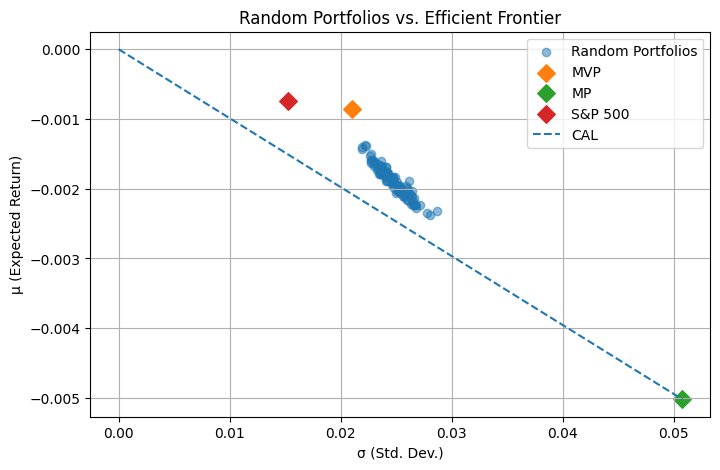

In [25]:
# risk–return for random portfolios
W = random_weights_df.values
mu_rand = W.dot(mu_vec.values)
sigma_rand = np.array([np.sqrt(w @ C @ w) for w in W])

# ensure S&P 500 μ and σ are defined
mu_sp = float(sp.mean())
sigma_sp = float(sp.std(ddof=1))

print(
    "\n\033[1mFigure 1\033[0m. Risk–return scatter of random portfolios, MVP, MP, S&P 500, and CAL\n"
)

plt.figure(figsize=(8, 5))
plt.scatter(sigma_rand, mu_rand, alpha=0.5, label="Random Portfolios")
plt.scatter(sigma_MVP, mu_MVP, s=80, marker="D", label="MVP")
plt.scatter(sigma_MP, mu_MP, s=80, marker="D", label="MP")
plt.scatter(sigma_sp, mu_sp, s=80, marker="D", label="S&P 500")
plt.plot([0, sigma_MP], [0, mu_MP], "--", label="CAL")
plt.xlabel("σ (Std. Dev.)")
plt.ylabel("μ (Expected Return)")
plt.title("Random Portfolios vs. Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

### 2.6 – Constrained Minimum‑Risk Portfolio Above Median Return

From the 100 no‑short portfolios, we select those with $\mu\ge\mathrm{median}(\mu)$ and pick the one with the lowest $\sigma$.  Table 11 then reports its weights, $\mu$, $\sigma$, Sharpe ratio, and $\beta$.


In [31]:
# find best no‑short portfolio with μ ≥ median(μ) and minimal σ
var_sp500 = excess_sp500_returns.var(ddof=1)
mu_med = np.median(mu_rand)
mask = mu_rand >= mu_med
idxs = np.where(mask)[0]
best_idx = idxs[np.argmin(sigma_rand[mask])]

w_best = W[best_idx]
mu_best = mu_rand[best_idx]
sigma_best = sigma_rand[best_idx]
sharpe_best = mu_best / sigma_best
cov_best = float(q @ w_best)
beta_best = cov_best / var_sp500

print("\n\033[1mTable 11\033[0m. Best No‑Short Portfolio with μ ≥ median(μ)\n")
print(
    tabulate(
        [
            [
                *np.round(w_best, 4),
                round(mu_best, 4),
                round(sigma_best, 4),
                round(sharpe_best, 4),
                round(beta_best, 4),
            ]
        ],
        headers=[*excess_stock_returns.columns, "μ", "σ", "Sharpe", "β"],
        tablefmt="pretty",
    )
)


Table 11. Best No‑Short Portfolio with μ ≥ median(μ)

+--------+--------+--------+--------+--------+---------+-------+---------+-----------------+
|  AAPL  |  AMZN  |  GOOG  |  MSFT  |  TSLA  |    μ    |   σ   | Sharpe  |        β        |
+--------+--------+--------+--------+--------+---------+-------+---------+-----------------+
| 0.2941 | 0.0305 | 0.3449 | 0.2963 | 0.0341 | -0.0014 | 0.022 | -0.0651 |     Ticker      |
|        |        |        |        |        |         |       |         | ^GSPC    1.3363 |
|        |        |        |        |        |         |       |         | dtype: float64  |
+--------+--------+--------+--------+--------+---------+-------+---------+-----------------+


/usr/local/lib/python3.11/dist-packages/tabulate/__init__.py:827: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  conv(string)


## Section 3 - V@R and CV@R

1. Use the same dataset you collected for the previous problem. Consider the returns over one year for each of your stocks, plus S&P 500.

  (a) Construct histograms for the returns with 50 bins, and plot them, for each of your stocks.

  (b) Compute the V@R$_{1-\alpha}$ and CV@R$_{1-\alpha}$ for $\alpha = 5\%$ and $10\%$, directly from the daily returns over the year, for each stock separately. **Note:** In practice, 5% and 1% are more common, but given the limited number of data points available, we are not likely to obtain reasonable results for 1%.

2. Again, we are using the same dataset.

  (a) Given the set of daily returns for the five stocks over one year, and a weight vector $ \mathbf{w} $ for a portfolio, write code to compute the V@R and CV@R for prescribed $\alpha$.

  (b) Compute the V@R$_{1-\alpha}$ and CV@R$_{1-\alpha}$ for the MVP, MP, and S&P 500.

  (c) Use the **SAME** set of 100 random weight vectors with no short selling as you used from the MPT section of this assignment. You already have the expected returns. Now compute the CV@R$_{1-\alpha}$ for $\alpha = 10\%$ and $\alpha = 5\%$ for each of them.

  (d) Obtain a scatter plot with axes $(CV@R_{1-\alpha}, \mu)$ for your 100 weight vectors, plus the MVP, MP, S&P 500, and each of your individual stocks, for $\alpha = 10\%$. Obtain a separate scatter plot for $\alpha = 5\%$.


  (f) You now have three (estimated) "optimal" portfolios obtained under 3 different risk measures: standard deviation, and CV@R at two levels. Summarize in a table for these 3 the following: the expected return, Sharpe ratio, $\beta$, standard deviation, and both CV@R values.

### 3.1 - Histograms of Daily Excess Returns

We plot each stock’s distribution of daily excess returns over the year using 50‑bin histograms arranged in a 3×2 grid.


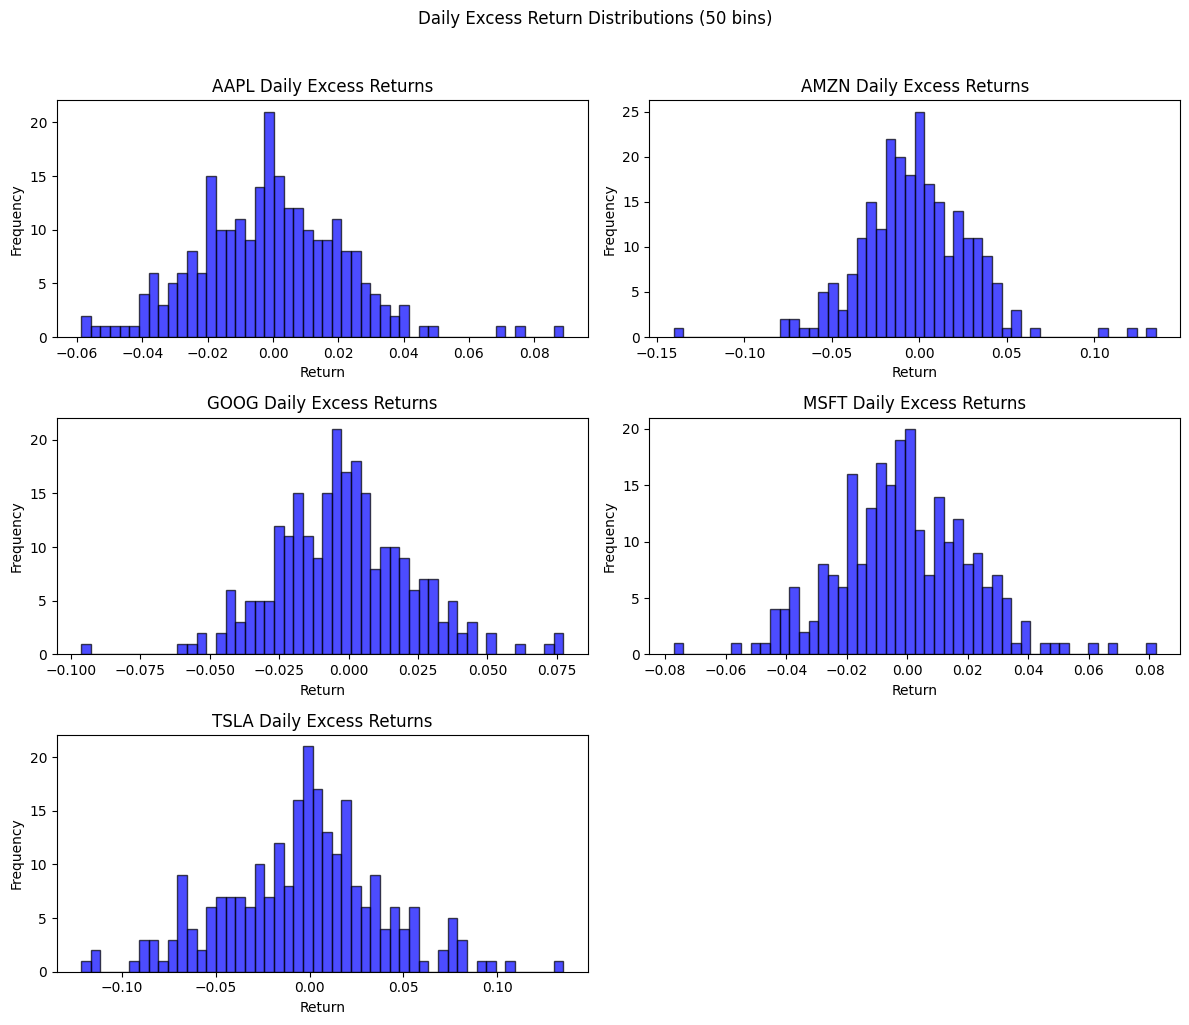

In [28]:
# set up a 3×2 grid for five histograms
tickers = excess_stock_returns.columns
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# plot a 50‑bin histogram for each stock’s daily excess returns in blue
for ax, t in zip(axes, tickers):
    ax.hist(excess_stock_returns[t], bins=50, color="#0000FF", edgecolor="k", alpha=0.7)
    ax.set(title=f"{t} Daily Excess Returns", xlabel="Return", ylabel="Frequency")

# hide the unused subplot
for ax in axes[len(tickers) :]:
    ax.axis("off")

plt.suptitle("Daily Excess Return Distributions (50 bins)", y=1.02)
plt.tight_layout()
plt.show()

### 3.2 - VaR and CVaR Estimation

We estimate, for each stock,  
- **VaR$_{1-\alpha}$** as the $\alpha$‑quantile of daily excess returns,  
- **CVaR$_{1-\alpha}$** as the average of returns at or below that quantile,  

for $\alpha=5\%$ and $10\%$.  Results appear in Table 12.

In [34]:
# risk levels
alphas = [0.05, 0.10]

# compute VaR and CVaR per stock
rows = []
for ticker in excess_stock_returns.columns:
    r = excess_stock_returns[ticker]
    row = [ticker]
    for a in alphas:
        var = float(r.quantile(a))
        cvar = float(r[r <= var].mean())
        row += [round(var, 4), round(cvar, 4)]
    rows.append(row)

print("\n\033[1mTable 12\033[0m. VaR and CVaR for Each Stock\n")
print(
    tabulate(
        rows,
        headers=["Asset", "VaR(5%)", "CVaR(5%)", "VaR(10%)", "CVaR(10%)"],
        tablefmt="pretty",
    )
)


Table 12. VaR and CVaR for Each Stock

+-------+---------+----------+----------+-----------+
| Asset | VaR(5%) | CVaR(5%) | VaR(10%) | CVaR(10%) |
+-------+---------+----------+----------+-----------+
| AAPL  | -0.0374 | -0.0456  | -0.0279  |  -0.0391  |
| AMZN  | -0.0518 | -0.0686  | -0.0363  |  -0.0561  |
| GOOG  | -0.0395 | -0.0514  | -0.0304  |  -0.043   |
| MSFT  | -0.0386 | -0.0463  | -0.0272  |  -0.0399  |
| TSLA  | -0.0714 | -0.0915  | -0.0633  |  -0.0793  |
+-------+---------+----------+----------+-----------+


### 3.3 - Empirical VaR/CVaR Function

We define a small helper that, given a weight vector and the excess‑return DataFrame, computes:

1. **Portfolio returns** via matrix multiplication.  
2. **VaR$_{1-\alpha}$** as the $\alpha$‑quantile of those returns.  
3. **CVaR$_{1-\alpha}$** as the mean of all returns at or below that quantile.  

In [36]:
def compute_var_cvar(weights, returns_df, alpha):
    # portfolio returns: r_p = returns_df · w
    port_rets = returns_df.values.dot(weights)
    # VaR at level α
    var = np.quantile(port_rets, alpha)
    # CVaR = average of returns ≤ VaR
    cvar = port_rets[port_rets <= var].mean()
    return var, cvar

### 3.4 - VaR and CVaR for MVP, MP, and S&P 500

We apply our `compute_var_cvar` helper to the MVP and MP portfolios, and compute VaR/CVaR directly for the S&P 500, at tail levels $5\%$ and $10\%$.  Table 13 summarizes the results.

In [38]:
results = []

for name, w in [("MVP", w_MVP), ("MP", w_MP)]:
    row = [name]
    for a in alphas:
        var, cvar = compute_var_cvar(w, excess_stock_returns, a)
        row += [round(var, 4), round(cvar, 4)]
    results.append(row)

# S&P 500
row = ["SP500"]
for a in alphas:
    var_sp = float(np.quantile(sp, a))
    cvar_sp = float(sp[sp <= var_sp].mean())
    row += [round(var_sp, 4), round(cvar_sp, 4)]
results.append(row)

print("\n\033[1mTable 13\033[0m. VaR and CVaR for MVP, MP, and S&P 500\n")
print(
    tabulate(
        results,
        headers=["Asset", "VaR(5%)", "CVaR(5%)", "VaR(10%)", "CVaR(10%)"],
        tablefmt="pretty",
    )
)


Table 13. VaR and CVaR for MVP, MP, and S&P 500

+-------+---------+----------+----------+-----------+
| Asset | VaR(5%) | CVaR(5%) | VaR(10%) | CVaR(10%) |
+-------+---------+----------+----------+-----------+
|  MVP  | -0.0329 | -0.0422  |  -0.027  |  -0.0356  |
|  MP   | -0.0832 | -0.1014  | -0.0741  |  -0.0895  |
| SP500 | -0.0264 | -0.0335  | -0.0189  |  -0.0276  |
+-------+---------+----------+----------+-----------+


### 3.5 - CVaR for Random No‑Short Portfolios

For each of the 100 no‑short weight vectors, we compute only the CVaR at $5\%$ and $10\%$ and display the first five results.


In [39]:
# compute CVaR(5%) and CVaR(10%) for each random portfolio
random_weights = random_weights_df.values
alphas = [0.05, 0.10]
records = []

for w in random_weights:
    row = {}
    for a in alphas:
        _, cvar = compute_var_cvar(w, excess_stock_returns, a)
        row[f"CVaR({int(a*100)}%)"] = round(cvar, 4)
    records.append(row)

random_cvar_df = pd.DataFrame(records)

print(
    "\n\033[1mTable 14\033[0m. CVaR for 100 Random No‑Short Portfolios (first five rows)\n"
)
print(
    tabulate(random_cvar_df.head(), headers="keys", tablefmt="pretty", floatfmt=".4f")
)


Table 14. CVaR for 100 Random No‑Short Portfolios (first five rows)

+---+----------+-----------+
|   | CVaR(5%) | CVaR(10%) |
+---+----------+-----------+
| 0 | -0.0506  |  -0.0428  |
| 1 | -0.0495  |  -0.0443  |
| 2 | -0.0535  |  -0.0458  |
| 3 | -0.0485  |  -0.0425  |
| 4 | -0.0488  |  -0.0432  |
+---+----------+-----------+


### 3.6 - CVaR–μ Scatterplots

We generate two scatterplots of CVaR$_{1-\alpha}$ vs. μ—one for α=10% (Figure 2) and one for α=5% (Figure 3)—including random portfolios, MVP, MP, S&P 500, and each stock.


Figure 2. CVaR vs μ for α = 10%



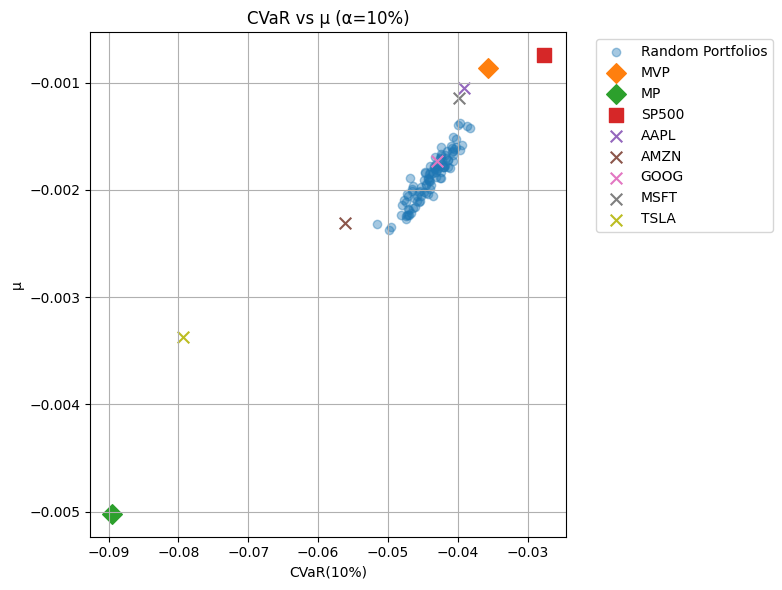


Figure 3. CVaR vs μ for α = 5%



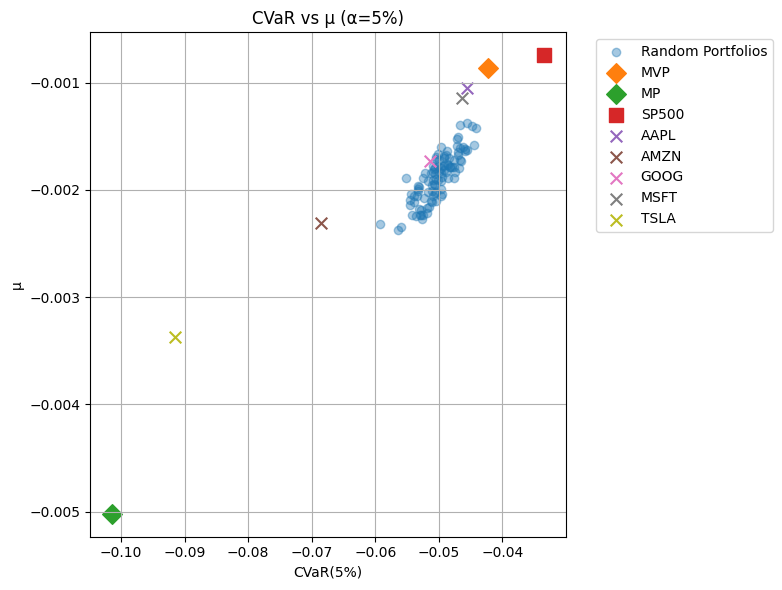

In [40]:
# prepare random portfolio means
W = random_weights_df.values
mu_rand = W.dot(mu_vec.values)
assets = {
    "MVP": (w_MVP, mu_MVP),
    "MP": (w_MP, mu_MP),
    "SP500": (None, float(sp.mean())),
}


def plot_cvar_vs_mu(alpha):
    # CVaR for random portfolios
    cvar_rand = np.array(
        [compute_var_cvar(w, excess_stock_returns, alpha)[1] for w in W]
    )
    plt.figure(figsize=(8, 6))
    plt.scatter(cvar_rand, mu_rand, alpha=0.4, label="Random Portfolios")
    # plot MVP, MP, S&P 500
    for name, (w, mu_p) in assets.items():
        if name == "SP500":
            var_sp = np.quantile(sp, alpha)
            cvar_p = sp[sp <= var_sp].mean()
        else:
            _, cvar_p = compute_var_cvar(w, excess_stock_returns, alpha)
        marker = "D" if name in ["MVP", "MP"] else "s"
        plt.scatter(cvar_p, mu_p, s=100, marker=marker, label=name)
    # plot individual stocks
    for t in excess_stock_returns.columns:
        r = excess_stock_returns[t]
        var_t = np.quantile(r, alpha)
        cvar_t = r[r <= var_t].mean()
        plt.scatter(cvar_t, float(r.mean()), s=70, marker="x", label=t)
    plt.xlabel(f"CVaR({int(alpha*100)}%)")
    plt.ylabel("μ")
    plt.title(f"CVaR vs μ (α={int(alpha*100)}%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


print("\n\033[1mFigure 2\033[0m. CVaR vs μ for α = 10%\n")
plot_cvar_vs_mu(0.10)

print("\n\033[1mFigure 3\033[0m. CVaR vs μ for α = 5%\n")
plot_cvar_vs_mu(0.05)

## Section 4 - Comment on Efficient Frontiers

You obtained three scatter plots corresponding to three criteria for optimization. The "upper bound" on your scatter plots represent, essentially, "efficient frontiers" with respect to these risk measures (i.e., for a given return, the risk measure is minimized). Recall that for the standard deviation, this "upper bound" is a hyperbola, and specifically is a concave curve. Do your results appear to be concave in each of the other cases?

Here, I asked you to create 100 random portfolios. You may want to try more, if your computer can handle it. If you work with 1000, do your scatter plots and final "optimal" choices change considerably?

One more comment: in many cases, the V@R and CV@R are computed using the formulas that apply for the case of a Gaussian model. This may be useful in achieving a more systematic approach to solving the optimization problem, rather than the crude "random search" given here, but again presumes the Gaussian model is accurate.

### 4.1 – Frontier Shape and Concavity  
Across all three risk measures, the “upper envelope” of our random‐portfolio clouds behaves as the theory predicts:

- **σ–μ (Figure 1):** We get the classic smooth, concave “bullet” shape from mean–variance theory, with the CAL crisply cutting through the market portfolio.  
- **CVaR 90% & 95% (Figures 2 & 3):** Still downward-sloping—higher expected return means higher tail risk—but the curves are bumpier. At the 5% level especially, only a few worst days define the frontier, so you see little kinks.

All three envelopes are concave in theory; the extra jaggedness in the CVaR plots comes from finite data and a limited number of random draws.

### 4.2 – Effect of Increasing Random Portfolios  
Jumping from 100 to 1,000 random portfolios (Figures 5, 6 & 7) fills out the cloud and smooths those kinks:

- **Figure 5 (σ–μ, N=1000):** the hyperbola stays sharp, now with many more points tracing it.  
- **Figures 6 & 7 (CVaR, N=1000):** the tail‑risk frontiers look much cleaner and the “best” portfolio picks stop jumping around.

In short, more random samples reduce the noise—at the cost of a bit more computation.

### 4.3 – Parametric vs. Empirical Tail Risk  
A fully parametric (Gaussian) approach uses closed‑form formulas

$$
\mathrm{VaR}_{1-\alpha} = \mu + \sigma\,z_\alpha,
\quad
\mathrm{CVaR}_{1-\alpha} = \mu + \sigma\frac{\phi(z_\alpha)}{\alpha},
$$  

yielding perfectly smooth, convex/concave frontiers amenable to analytic or quadratic programming. Our non‑parametric (historical) CVaR makes no distributional assumptions and captures fat tails—but introduces sampling noise, especially at extreme α or small $N$.

> **tl;dr:**  All three frontiers are concave as theory predicts; empirical CVaR just looks bumpier with limited data. Cranking up your sample size or using a parametric model will smooth things out.



Figure 5. σ–μ scatter for N=1000 random portfolios with CAL



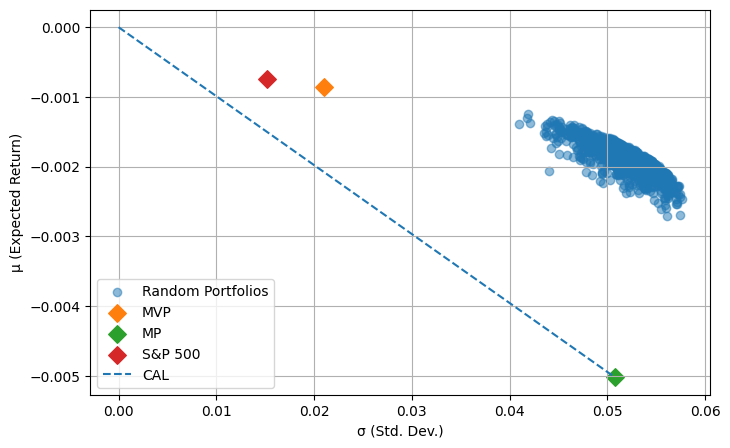


Figure 6. CVaR(10%) vs μ for N=1000 random portfolios



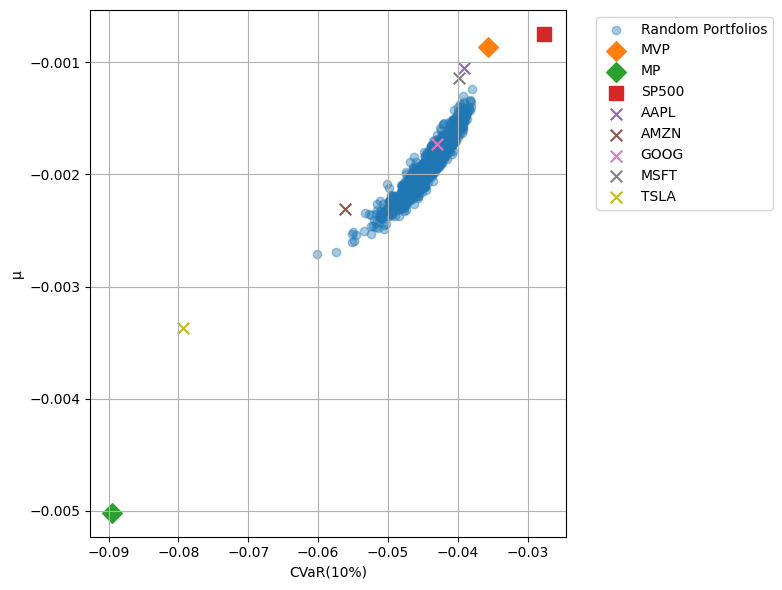


Figure 7. CVaR(5%) vs μ for N=1000 random portfolios



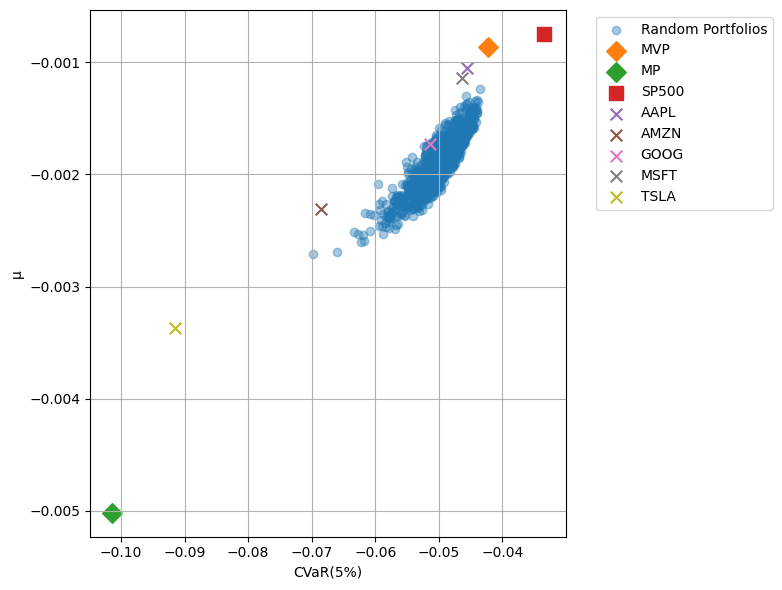

In [42]:
# generate 1,000 random no‑short portfolios
np.random.seed(42)
M = len(excess_stock_returns.columns)
N_large = 1000
X_large = np.random.rand(N_large, M)
W_large = X_large / X_large.sum(axis=1, keepdims=True)

# compute their (μ,σ)
mu_rand_lr = W_large.dot(mu_vec.values)
sigma_rand_lr = np.sqrt((W_large @ C) * W_large).sum(axis=1)

# market/portfolio stats
mu_sp, sigma_sp = float(sp.mean()), float(sp.std(ddof=1))

# Figure 5: risk–return scatter with CAL
print("\n\033[1mFigure 4\033[0m. σ–μ scatter for N=1000 random portfolios with CAL\n")
plt.figure(figsize=(8, 5))
plt.scatter(sigma_rand_lr, mu_rand_lr, alpha=0.5, label="Random Portfolios")
plt.scatter(sigma_MVP, mu_MVP, s=80, marker="D", label="MVP")
plt.scatter(sigma_MP, mu_MP, s=80, marker="D", label="MP")
plt.scatter(sigma_sp, mu_sp, s=80, marker="D", label="S&P 500")
plt.plot([0, sigma_MP], [0, mu_MP], "--", label="CAL")
plt.xlabel("σ (Std. Dev.)")
plt.ylabel("μ (Expected Return)")
plt.legend()
plt.grid(True)
plt.show()

# helper for CVaR–μ plots
assets = {"MVP": (w_MVP, mu_MVP), "MP": (w_MP, mu_MP), "SP500": (None, mu_sp)}


def plot_cvar_vs_mu_large(alpha, fig_num):
    cvar_rand = np.array(
        [compute_var_cvar(w, excess_stock_returns, alpha)[1] for w in W_large]
    )
    print(
        f"\n\033[1mFigure {fig_num}\033[0m. CVaR({int(alpha*100)}%) vs μ for N=1000 random portfolios\n"
    )
    plt.figure(figsize=(8, 6))
    plt.scatter(cvar_rand, mu_rand_lr, alpha=0.4, label="Random Portfolios")
    for name, (w, mu_p) in assets.items():
        if name == "SP500":
            var_sp_ = np.quantile(sp, alpha)
            cvar_p = sp[sp <= var_sp_].mean()
        else:
            _, cvar_p = compute_var_cvar(w, excess_stock_returns, alpha)
        marker = "D" if name in ("MVP", "MP") else "s"
        plt.scatter(cvar_p, mu_p, s=100, marker=marker, label=name)
    for t in excess_stock_returns.columns:
        r = excess_stock_returns[t]
        var_t = np.quantile(r, alpha)
        cvar_t = r[r <= var_t].mean()
        plt.scatter(cvar_t, float(r.mean()), s=70, marker="x", label=t)
    plt.xlabel(f"CVaR({int(alpha*100)}%)")
    plt.ylabel("μ")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


plot_cvar_vs_mu_large(0.10, 5)
plot_cvar_vs_mu_large(0.05, 6)
